# ISPR 2025 - Midterm 2 - Assignament 3 - Gianluca Panzani (550358)

## MNIST dataset
The dataset contains flattened grayscale images of handwritten digits. In the following part of the code, the images are loaded and normalized from values in range [0,255] to [0,1].

In [161]:
import numpy as np
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, rows * cols)
        return data / 255.0
    
def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

X_train = load_images('mnist/train-images.idx3-ubyte')
y_train = load_labels('mnist/train-labels.idx1-ubyte')

X_test = load_images('mnist/t10k-images.idx3-ubyte')
y_test = load_labels('mnist/t10k-labels.idx1-ubyte')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


## Restricted Boltzmann Machine
In this block is defined the RBM class. The methods are described into the documentation.

In [162]:
class RBM:
    '''
    Restricted Boltzmann Machine (RBM) implementation: a generative stochastic neural network 
    that can learn a probability distribution over its set of inputs.

    Attributes:
        - n_visible (int): number of visible units (input features).
        - n_hidden (int): number of hidden units (latent features).
        - M (np.ndarray): weight matrix of shape (n_visible, n_hidden), initialized randomly.
        - b (np.ndarray): bias vector for visible units of shape (n_visible).
        - c (np.ndarray): bias vector for hidden units of shape (n_hidden).
    '''
    def __init__(self, n_visible: int, n_hidden: int):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # Weights initialization (generated randomly samples from a normal Gaussian distribution)
        self.M = np.random.normal(0, 0.01, size=(n_visible, n_hidden))

        # Bias initialization (initially zeros) for visible and hidden layers respectively
        self.b = np.zeros(n_visible)
        self.c = np.zeros(n_hidden)

    def sigmoid(self, x: np.ndarray):
        '''
        Sigmoid activation function, defined as: 1 / (1 + exp(-x)), which maps any real
        number to the (0,1) interval of probability.

        Params:
            - x (np.ndarray): input array.

        Returns:
            - np.ndarray: output array with the sigmoid function applied element-wise.
        '''
        return 1.0 / (1.0 + np.exp(-x))

    def __sample_prob(self, probs: np.ndarray):
        '''
        Samples binary activations based on given probabilities. For each element in the input array,
        a random number is generated and compared to the probability. If the random number is less than
        the probability: the output is 1, otherwise: the output is 0.

        Params:
            - probs (np.ndarray): array of probabilities.

        Returns:
            - np.ndarray: binary (0 or 1) sampled activations.
        '''
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)
    
    def v_to_h(self, v: np.ndarray):
        '''
        Performs a forward pass from the visible layer to the hidden layer. Computes the activation
        probabilities of the hidden units given the visible input and then samples binary activations.

        Params:
            - v (np.ndarray): binary input array representing the state of the visible units.

        Returns:
            - h_prob (np.ndarray): probabilities of the hidden units to be activated.
            - h_sample (np.ndarray): sampled binary states of the hidden units.
        '''
        h_prob = self.sigmoid(np.dot(v, self.M) + self.c) # sigma(vW + c)
        h_sample = self.__sample_prob(h_prob)
        return h_prob, h_sample

    def h_to_v(self, h: np.ndarray):
        '''
        Performs a backward pass from the hidden layer to the visible layer. Computes the activation
        probabilities of the visible units given the hidden input and then samples binary reconstructions.

        Params:
            - h (np.ndarray): Binary input array representing the state of the hidden units.

        Returns:
            - v_prob (np.ndarray): probabilities of the visible units to be activated.
            - v_sample (np.ndarray): sampled binary states of the visible units.
        '''
        v_prob = self.sigmoid(np.dot(h, self.M.T) + self.b) # sigma(hM^T + b)
        v_sample = self.__sample_prob(v_prob)
        return v_prob, v_sample
    
    def contrastive_divergence(self, v0: np.ndarray, lr: float = 0.1, k: int = 1):
        '''
        Performs Contrastive Divergence (CD-k) to update the model's weights and biases. CD approximates the
        gradient of the log-likelihood by comparing real data with reconstructions.

        Params:
            - v0 (np.ndarray): a single batch of visible units (from the input data).
            - lr (float): learning rate for weight and bias updates.
            - k (int): number of Gibbs sampling steps.

        Returns:
            - loss (float): mean squared reconstruction error on the batch.
        '''

        # Positive phase
        h0_prob, h0_sample = self.v_to_h(v0)
        # Gibbs sampling (k full steps)
        vk_sample = v0
        hk_sample = h0_sample
        for i in range(k):
            vk_prob, vk_sample = self.h_to_v(hk_sample) # visible <- hidden
            hk_prob, hk_sample = self.v_to_h(vk_sample) # visible -> hidden
        vk = vk_sample
        hk = hk_sample

        # Negative phase
        # Gradient computed on real data (and real probability distribution)
        positive_grad = np.dot(v0.T, h0_prob) # v0^T h0
        # Gradient computed on sampled data (and sampled probability distribution)
        negative_grad = np.dot(vk.T, hk_prob) # vk^T hk

        # Update of Weights matrix and Bias vectors
        batch_size = v0.shape[0]
        self.M += lr * (positive_grad - negative_grad) / batch_size
        self.b += lr * np.mean(v0 - vk, axis=0)
        self.c += lr * np.mean(h0_prob - hk_prob, axis=0)

        # Return the loss between the real visible data and the sampled one after k steps of Gibbs sampling
        return np.mean((v0 - vk) ** 2)


## Training of two RBMs with different values of K
This section trains two Restricted Boltzmann Machines (RBMs) with the same architecture (784 visible units and 128 hidden units) but different values of K for the Contrastive Divergence (CD) algorithm. Specifically, RBM1 is trained using CD-1 (K=1), while RBM2 uses CD-10 (K=10).

The training is performed over 10 epochs using mini-batches of size 64 and a learning rate of 0.1. For each epoch, the model computes the average loss, with Mean Squared Error (MSE), across all batches and stores it for later analysis.

The goal of this training is to compare how different values of K affect the learning process and the quality of the representations learned by the RBMs.

In [163]:
# Hyperparameters
n_epochs = 10
lr = 0.1
k1 = 1
k2 = 10
batch_size = 64
n_batches = X_train.shape[0] // batch_size
print(f'Hyperparameters: k1={k1}, k2={k2}, learning_rate={lr}, batch_size={batch_size}')

# Create two equals Restricted Boltzmann Machines
rbm1 = RBM(784,128)
rbm2 = RBM(784,128)

# Batch iterations
losses1 = []
losses2 = []
for epoch in range(n_epochs):
    sum_loss1 = sum_loss2 = 0
    for i in range(0, X_train.shape[0], batch_size):
        v0 = X_train[i:i + batch_size]
        loss1 = rbm1.contrastive_divergence(v0, lr=lr, k=k1)
        loss2 = rbm2.contrastive_divergence(v0, lr=lr, k=k2)
        sum_loss1 += loss1
        sum_loss2 += loss2
    avg_loss1 = sum_loss1 / n_batches
    avg_loss2 = sum_loss2 / n_batches
    losses1.append(avg_loss1)
    losses2.append(avg_loss2)
    print(f'Epoch {epoch+1}/{n_epochs} - Loss 1: {avg_loss1:.4f} - Loss 2: {avg_loss2:.4f}')


Hyperparameters: k1=1, k2=10, learning_rate=0.1, batch_size=64
Epoch 1/10 - Loss 1: 0.0915 - Loss 2: 0.1260
Epoch 2/10 - Loss 1: 0.0653 - Loss 2: 0.0920
Epoch 3/10 - Loss 1: 0.0593 - Loss 2: 0.0853
Epoch 4/10 - Loss 1: 0.0560 - Loss 2: 0.0815
Epoch 5/10 - Loss 1: 0.0537 - Loss 2: 0.0790
Epoch 6/10 - Loss 1: 0.0521 - Loss 2: 0.0772
Epoch 7/10 - Loss 1: 0.0508 - Loss 2: 0.0758
Epoch 8/10 - Loss 1: 0.0498 - Loss 2: 0.0746
Epoch 9/10 - Loss 1: 0.0490 - Loss 2: 0.0737
Epoch 10/10 - Loss 1: 0.0484 - Loss 2: 0.0731


## Comparison between reconstruction loss functions
This plot shows the reconstruction loss functions over 10 training epochs for two RBMs trained with different values of K in the Contrastive Divergence algorithm.

RBM1 (k=1) reaches a lower reconstruction loss compared to RBM2 (k=10), likely because its weights are updated based on a lower number of Gibbs sampling steps. This leads to sharper reconstructions but may focus more on pixel-level details rather than high-level features.

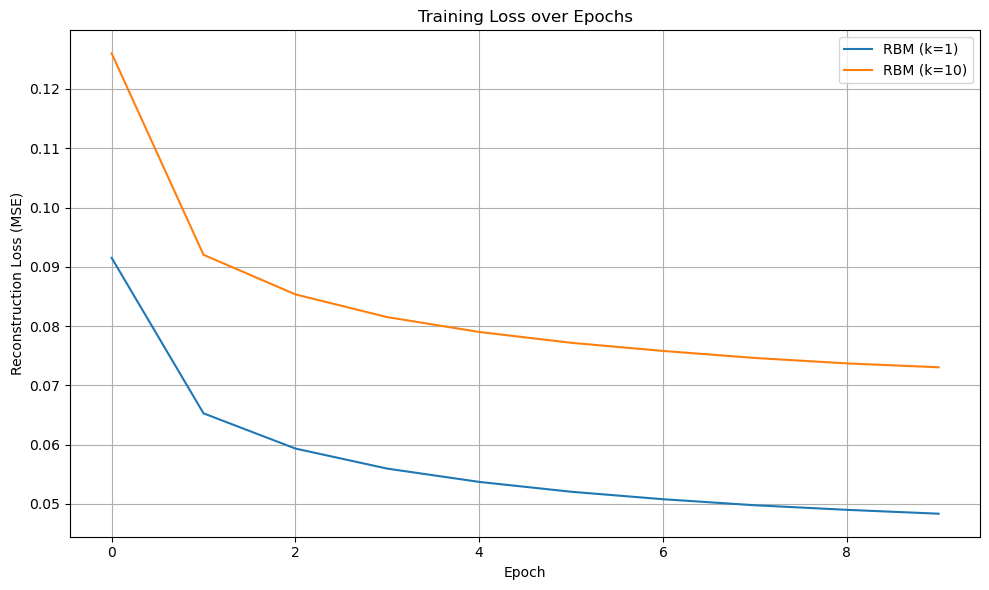

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses1, label=f'RBM (k={k1})')
plt.plot(losses2, label=f'RBM (k={k2})')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Classification task
After training the RBMs with k=1 and k=10, the hidden layer activations were used as feature representations to train two separate Logistic Regression classifiers. The goal was to evaluate the learned representations for the digit classification task.

RBM2 produces higher reconstruction loss, but, the higher number of Gibbs sampling steps, allows it to learn more abstract and generalizable hidden features. These features are more useful for classification, leading to a slightly better accuracy.

The result confirms that CD-1 remains a strong and efficient choice, especially with simple images/tasks like handwritten digits, but with more complex ones could be better a higher value of K to learn higher-level features.

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Encode training set with both RBMs
_, H_train_1 = rbm1.v_to_h(X_train)
_, H_test_1 = rbm1.v_to_h(X_test)
_, H_train_2 = rbm2.v_to_h(X_train)
_, H_test_2 = rbm2.v_to_h(X_test)

# Training of classifiers
clf1 = LogisticRegression(max_iter=1000)
clf2 = LogisticRegression(max_iter=1000)
clf1.fit(H_train_1, y_train)
clf2.fit(H_train_2, y_train)

# Predictions on test sets
y_pred_1 = clf1.predict(H_test_1)
y_pred_2 = clf2.predict(H_test_2)

# Compute the accuracy
acc1 = accuracy_score(y_test, y_pred_1)
acc2 = accuracy_score(y_test, y_pred_2)

print(f'Accuracy with RBM1 (k={k1}): {acc1:.4f}')
print(f'Accuracy with RBM2 (k={k2}): {acc2:.4f}')

Accuracy with RBM1 (k=1): 0.9211
Accuracy with RBM2 (k=10): 0.9254


## Reconstruction
The following figure compares the reconstruction quality of three MNIST digits using two RBMs.

For each digit (from 0 to 9) the original image is shown on the left, followed by the reconstructions produced by RBM1 (K=1) and RBM2 (K=10), respectively.

Visually, both RBMs are able to capture the general structure of the digits, but RBM2 tends to produce slightly more accurate reconstructions. In fact, RBM1 shows more blurring and noise in some parts of the images.

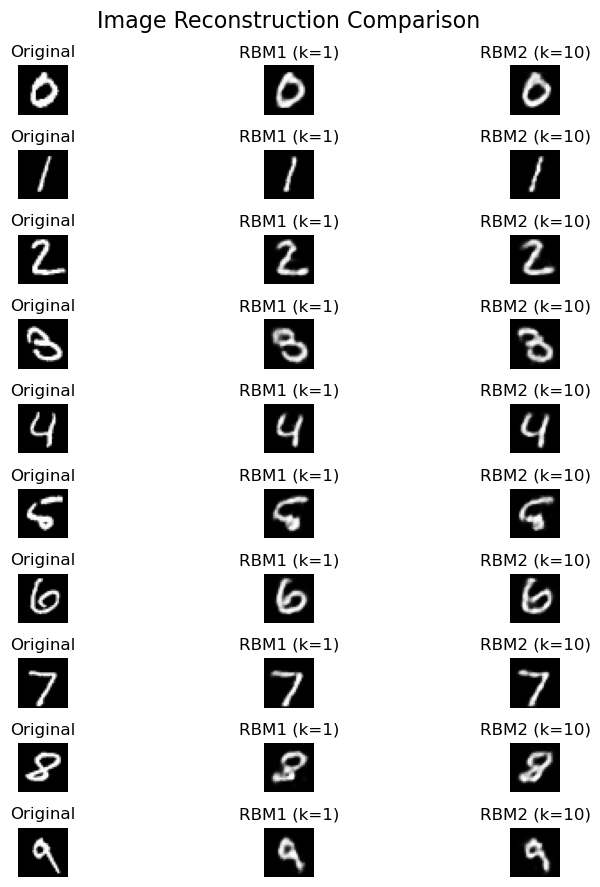

In [167]:
# Pick the first sample for each different digit
samples = np.array([X_test[y_test == digit][0] for digit in list(range(10))])

# Reconstruction with both RBMs
_, h1 = rbm1.v_to_h(samples)
_, h2 = rbm2.v_to_h(samples)
v1_recon_prob, _ = rbm1.h_to_v(h1)
v2_recon_prob, _ = rbm2.h_to_v(h2)

# Plot of the reconstructed images
fig, axes = plt.subplots(10, 3, figsize=(9, 9))
for i in range(10):

    # Original
    axes[i,0].imshow(samples[i].reshape(28, 28), cmap='gray')
    axes[i,0].set_title('Original')
    axes[i,0].axis('off')

    # RBM1
    axes[i,1].imshow(v1_recon_prob[i].reshape(28, 28), cmap='gray')
    axes[i,1].set_title(f'RBM1 (k={k1})')
    axes[i,1].axis('off')

    # RBM2
    axes[i,2].imshow(v2_recon_prob[i].reshape(28, 28), cmap='gray')
    axes[i,2].set_title(f'RBM2 (k={k2})')
    axes[i,2].axis('off')

plt.suptitle('Image Reconstruction Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## Conclusions
In this experiment, both RBMs achieved good reconstruction quality and classification performance. RBM1 (K=1) consistently produced lower reconstruction loss, while RBM2 (K=10) achieved slightly higher classification accuracy (92.54% vs 92.11%).

These results confirm that CD-1 is efficient and effective for simple image datasets like MNIST, but a higher value of K can lead to more abstract and discriminative feature representations, resulting in better classification and reconstruction performance.

Overall, the trade-off between reconstruction quality and generalization ability highlights the importance of selecting K based on the aim of the task.